In [1]:
from datasets import DatasetDict
import torch
import umap
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
def plot_embeddings(embeddings: torch.tensor, labels:list, title = "plot", method="pca", aggregation="mean"):
    """
    Plot embeddings using PCA or UMAP
    """

    # Create a PCA object
    if method == "umap":
        reducer = umap.UMAP()
    elif method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=5, n_iter=250)
    else:
        raise ValueError("Reducer Method not implemented")

    # Aggregate embeddings along sequence dimension
    if aggregation == "mean":
        embeddings = torch.mean(embeddings, dim=1)
    elif aggregation == "cls":
        embeddings = embeddings[:,0,:]
    else:
        raise ValueError("Aggregation method not implemented")

    # Fit and transform the embeddings using the PCA object
    principalComponents = reducer.fit_transform(embeddings)

    # Create a dataframe with the embeddings and the corresponding labels
    df_embeddings = pd.DataFrame(principalComponents, columns=['x', 'y'])
    df_embeddings['label'] = labels
    
    for label in df_embeddings['label'].unique():
        _df = df_embeddings[df_embeddings['label'] == label]
        plt.scatter(_df['x'], _df['y'], alpha=0.5)
        plt.legend(df_embeddings['label'].unique())

    # Add a title and show the plot
    plt.title(title)

    plt.show()

In [3]:
def summarise_line_label_performance(embeddings_path: str, predictions_path: str):
    # Load embeddings
    embeddings = torch.load(embeddings_path)

    # Load predictions
    predictions = torch.load(predictions_path)

    # Load dataset
    dataset = DatasetDict.load_from_disk(paths.DATA_PATH_PREPROCESSED/'line_labelling_clean_dataset')

    # Import label dict
    import json
    with open(os.path.join(paths.DATA_PATH_PREPROCESSED, "line_labelling_clean_class_mapping.json"), "r") as f:
        label_dict = json.load(f)
        
    # Accuracy
    preds = np.argmax(predictions.predictions, axis=1)
    labels = np.argmax(predictions.label_ids, axis=1)

    print(f"Accuracy: {np.sum(preds == labels) / len(labels)}")
    
    # f1 score, precision, recall
    print(f"F1 Score: {f1_score(labels, preds, average='weighted')}")
    print(f"Precision: {precision_score(labels, preds, average='weighted')}")
    print(f"Recall: {recall_score(labels, preds, average='weighted')}")
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(labels, preds, xticks_rotation=90, display_labels=list(label_dict.values()))
    
    # Plot embeddings PCA
    plt.figure(figsize=(8, 6))
    plot_embeddings(embeddings=embeddings, labels=dataset["test"]["class_agg"], title=str(embeddings_path).split("/")[-1]+ " PCA", method="pca", aggregation="mean")
    
    # Plot embeddings UMAP
    plt.figure(figsize=(8, 6))
    plot_embeddings(embeddings=embeddings, labels=dataset["test"]["class_agg"], title=str(embeddings_path).split("/")[-1]+ " UMAP", method="umap", aggregation="mean")

## Medbert Line Label Performance

Accuracy: 0.914364640883978
F1 Score: 0.9133071962118666
Precision: 0.9141944572133995
Recall: 0.914364640883978


<Figure size 800x600 with 0 Axes>

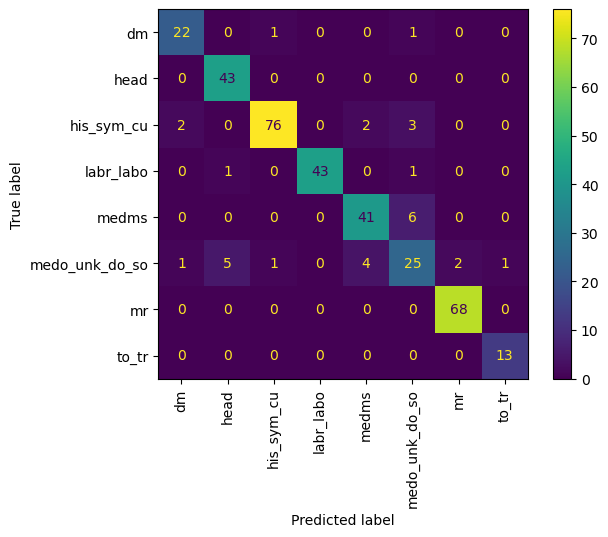

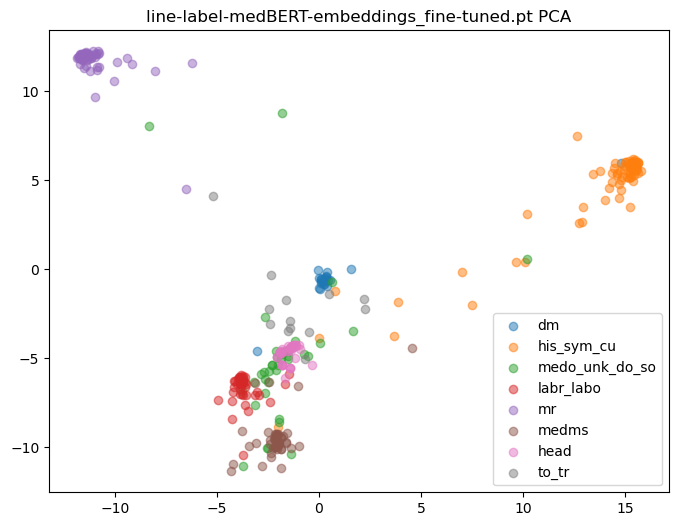

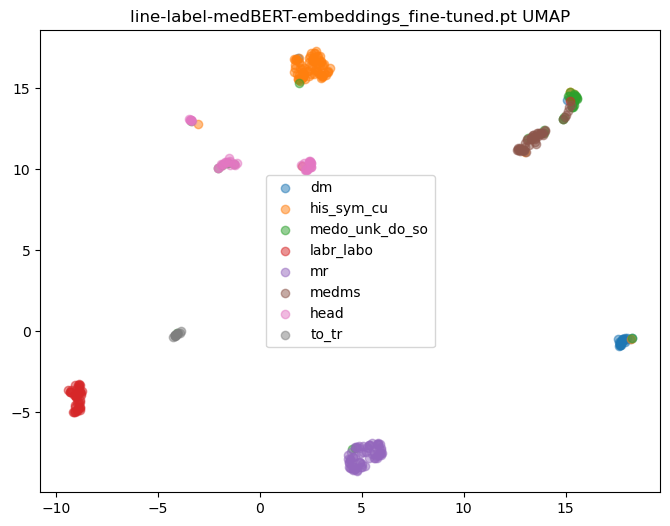

In [4]:
summarise_line_label_performance(paths.DATA_PATH_PREPROCESSED/'line-label_pred'/'line-label-medBERT-embeddings_fine-tuned.pt',
                                paths.DATA_PATH_PREPROCESSED/'line-label_pred'/'line-label-medBERT-predictions_fine-tuned.pt')

## Bert Base Multilingual cased Performance

Accuracy: 0.8977900552486188
F1 Score: 0.8962043063939432
Precision: 0.9000516002706733
Recall: 0.8977900552486188


<Figure size 800x600 with 0 Axes>

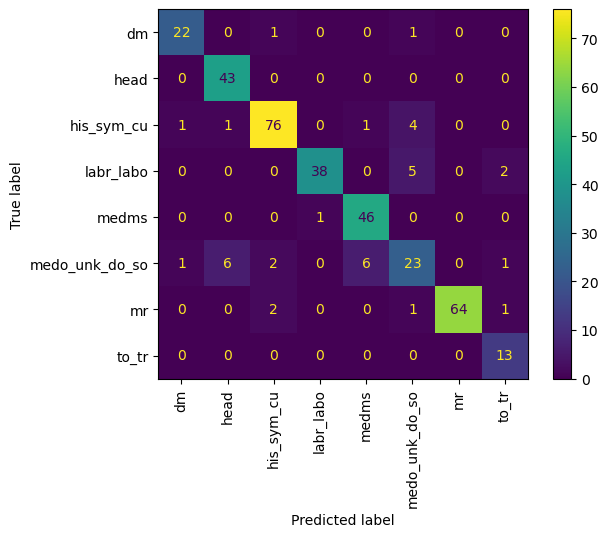

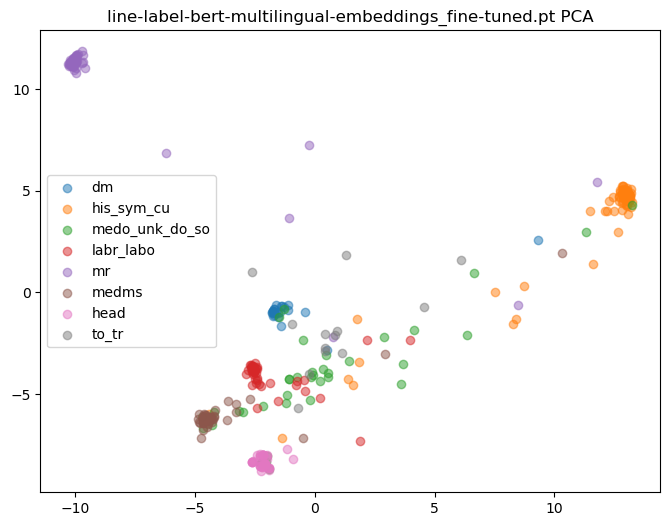

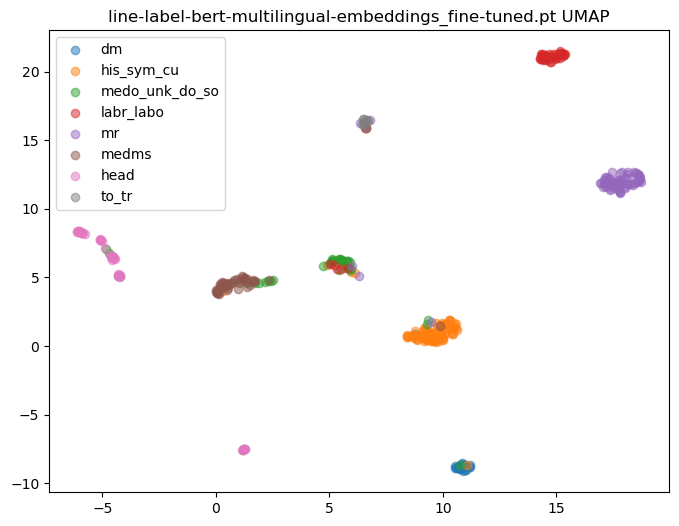

In [5]:
summarise_line_label_performance(paths.DATA_PATH_PREPROCESSED/'line-label_pred'/'line-label-bert-multilingual-embeddings_fine-tuned.pt',
                                paths.DATA_PATH_PREPROCESSED/'line-label_pred'/'line-label-bert-multilingual-predictions_fine-tuned.pt')